In [1]:
import diff_classifier.aws as aws
import pandas as pd
import boto3
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy.optimize import leastsq
from scipy.stats import sem

In [2]:
def intersection(x1,y1,x2,y2):
    """
    Adapted from sukhbinder at 
    https://github.com/sukhbinder/intersection/blob/master/intersection.py
    
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.

usage:
x,y=intersection(x1,y1,x2,y2)

    Example:
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)

    x2=phi
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)

    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()

    """
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]


def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4


def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

In [3]:
def fit_sine(x, y, guess_freq=1/150):

    guess_mean = np.mean(y)
    guess_std = 3*np.std(y)/(2**0.5)/(2**0.5)
    guess_slope = 0
    if x.shape[0] > 8:
        guess_freq = 1/(0.7*np.average(np.diff(x)))
        guess_amp = 2*(min(y) - max(y))
    else:
        guess_freq = 1/(0.5*np.average(np.diff(x)))
        guess_amp = 0.75*np.ptp(y)
        
    guess_phase = np.arcsin((y[0] - guess_mean)/guess_amp) - x[0]
    
    # we'll use this to plot our first estimate. This might already be good enough for you
    data_first_guess = guess_std*np.sin(x+guess_phase) + guess_mean + guess_slope*x

    # Define the function to optimize, in this case, we want to minimize the difference
    # between the actual data and our "guessed" parameters
    if x.shape[0] > 8:
        optimize_func = lambda z: z[0]*np.sin(z[1]*x+z[2]) + z[3] +z[4]*x - y
        est_amp, est_freq, est_phase, est_mean, est_slope = leastsq(optimize_func,
                                                                [guess_amp, guess_freq,
                                                                 guess_phase, guess_mean, guess_slope])[0]

    else:
        optimize_func = lambda z: guess_amp*np.sin(z[0]*x+z[1]) + z[2] +z[3]*x - y
        est_freq, est_phase, est_mean, est_slope = leastsq(optimize_func,
                                                                [guess_freq,
                                                                 guess_phase, guess_mean, guess_slope])[0]
        est_amp, est_freq, est_phase, est_mean, est_slope = guess_amp, guess_freq, guess_phase, guess_mean, guess_slope

    # recreate the fitted curve using the optimized parameters
    data_fit = est_amp*np.sin(est_freq*x+est_phase) + est_mean + est_slope*x

    # recreate the fitted curve using the optimized parameters

    fine_t = np.arange(0,max(x),0.1)
    data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean+est_slope*fine_t
    
    return fine_t, data_fit, est_amp, est_freq

In [10]:
def ferret_fit(folder, prefix, download=True, bucket_name='ccurtis.data'):
    
    filename = '{}.csv'.format(prefix)
    if download:
        aws.download_s3('{}/{}'.format(folder, filename), filename, bucket_name=bucket_name)
    ferret_data = pd.read_csv(filename)
    ferret_data = ferret_data.sort_values(by=['X'])
    length = ferret_data.shape[0]

    x = ferret_data['X']
    y = ferret_data['Y']
    fine_t, data_fit, est_amp, est_freq = fit_sine(x, y, guess_freq=1/100)

    lowess = sm.nonparametric.lowess
    ymid = lowess(y, x, frac=0.3)
    yavg = np.convolve(y, np.ones((length,))/length, mode='same')

    strait = np.mean(y)*np.ones((length,))
    intersections = intersection(x, ymid[:,1], x, strait)
    pawcount = len(x)
    pawdens = np.abs(100*pawcount/(max(x) - min(x)))
    stride = np.mean(np.diff(x))
    stridestd = np.std(np.diff(x))
    
    plt.figure(figsize=(10, 5))
    plt.scatter(x, y, s=300)
    plt.plot(x, ymid[:, 1], linewidth=6)
    plt.plot(x, strait, 'k', linewidth=6)
    plt.plot(fine_t, data_fit, 'm', linewidth=6)
    #plt.plot(x, yavg, 'k', linewidth=6)
    plt.ylim(0, 120)
    imfile = '{}_fit.png'.format(prefix)
    plt.savefig(imfile)
    aws.upload_s3(imfile, '{}/{}'.format(folder, imfile), bucket_name='ccurtis.data')
    
    ystd = np.round(np.std(y), 2)
    yrange = np.round(np.ptp(y), 2)
    rsd = 100*np.round(ystd/np.mean(y), 2)
    cross = len(intersections[0])
    crossdens = np.abs(100*cross/(max(x) - min(x)))

    print('Video to analyze: {}'.format(filename))
    print('Deviation from midline: {}'.format(ystd))
    print('Range in y: {}'.format(yrange))
    print('Percent deviation from midline: {}'.format(rsd))
    print('Fit amplitude: {}'.format(np.abs(np.round(est_amp, 2))))
    print('Number of intersections: {}'.format(cross))
    print('Number of intersections per 100 pixels: {}'.format(np.round(crossdens)))
    print('Number of footprints: {}'.format(pawcount))
    print('Number of footprints per 100 pixels: {}'.format(np.round(pawdens)))
    print('Average stride: {}'.format(np.round(stride)))
    print('Stride deviation: {}'.format(np.round(stridestd)))
    print('Fit period: {}\n'.format(np.round(1/est_freq, 2)))
    
    
    return (ystd, yrange, rsd, np.abs(est_amp), 1/est_freq, pawcount, pawdens, cross, crossdens, stride, stridestd)

# Example use of ferret_fit

Video to analyze: N_P1_R1.csv
Deviation from midline: 22.94
Range in y: 63.97
Percent deviation from midline: 40.0
Fit amplitude: 28.33
Number of intersections: 7
Number of intersections per 100 pixels: 1.0
Number of footprints: 15
Number of footprints per 100 pixels: 3.0
Average stride: 36.0
Stride deviation: 8.0
Fit period: 22.89



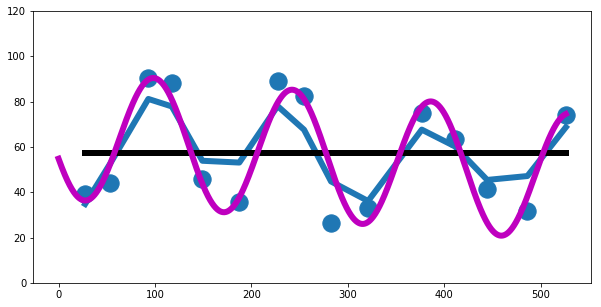

In [9]:
prefix = 'N_P1_R1'
folder = 'ferret_tracking'
test = ferret_fit(folder, prefix)

# Example code to loop over multiple tracks

In [11]:
#This cell creates a list of csv names over which we will loop

s3 = boto3.resource('s3')
my_bucket = s3.Bucket('ccurtis.data')

all_files = []
for object_summary in my_bucket.objects.filter(Prefix=folder):
    all_files.append(object_summary.key)
    
all_csvs = []
for num in all_files:
    if 'csv' in num:
        all_csvs.append(num.split('/')[1].split('.')[0])

In [ ]:
all_csvs[0:-2]

Video to analyze: N_P1_R1.csv
Deviation from midline: 22.94
Range in y: 63.97
Percent deviation from midline: 40.0
Fit amplitude: 28.33
Number of intersections: 7
Number of intersections per 100 pixels: 1.0
Number of footprints: 15
Number of footprints per 100 pixels: 3.0
Average stride: 36.0
Stride deviation: 8.0
Fit period: 22.89

Video to analyze: N_P1_R2.csv
Deviation from midline: 23.74
Range in y: 61.58
Percent deviation from midline: 43.0
Fit amplitude: 6.5
Number of intersections: 7
Number of intersections per 100 pixels: 1.0
Number of footprints: 10
Number of footprints per 100 pixels: 2.0
Average stride: 61.0
Stride deviation: 23.0
Fit period: 45.57

Video to analyze: N_P1_R3.csv
Deviation from midline: 20.37
Range in y: 58.9
Percent deviation from midline: 42.0
Fit amplitude: 24.75
Number of intersections: 8
Number of intersections per 100 pixels: 2.0
Number of footprints: 17
Number of footprints per 100 pixels: 3.0
Average stride: 33.0
Stride deviation: 7.0
Fit period: 21.3

/home/ubuntu/miniconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Video to analyze: W_P3_R1.csv
Deviation from midline: 18.73
Range in y: 53.1
Percent deviation from midline: 22.0
Fit amplitude: 12.47
Number of intersections: 7
Number of intersections per 100 pixels: 1.0
Number of footprints: 10
Number of footprints per 100 pixels: 2.0
Average stride: 55.0
Stride deviation: 26.0
Fit period: 31.79

Video to analyze: W_P3_R2.csv
Deviation from midline: 24.79
Range in y: 78.04
Percent deviation from midline: 37.0
Fit amplitude: 31.54
Number of intersections: 9
Number of intersections per 100 pixels: 2.0
Number of footprints: 14
Number of footprints per 100 pixels: 3.0
Average stride: 42.0
Stride deviation: 24.0
Fit period: 22.86

Video to analyze: W_P3_R3.csv
Deviation from midline: 21.27
Range in y: 58.44
Percent deviation from midline: 28.000000000000004
Fit amplitude: 11.27
Number of intersections: 6
Number of intersections per 100 pixels: 1.0
Number of footprints: 9
Number of footprints per 100 pixels: 2.0
Average stride: 64.0
Stride deviation: 28.0

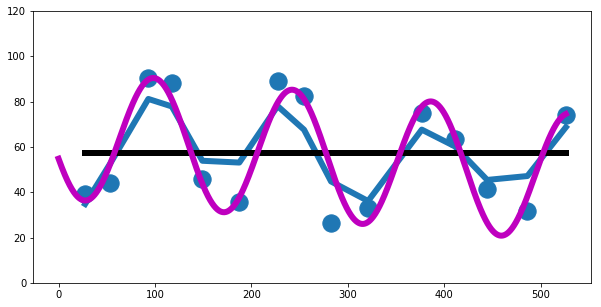

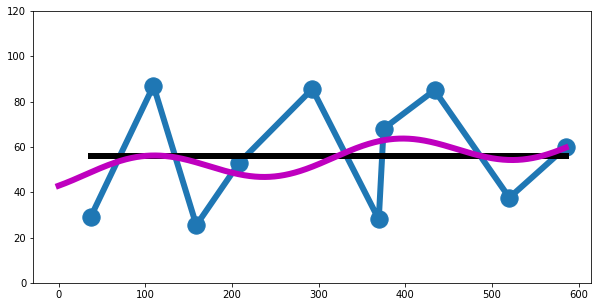

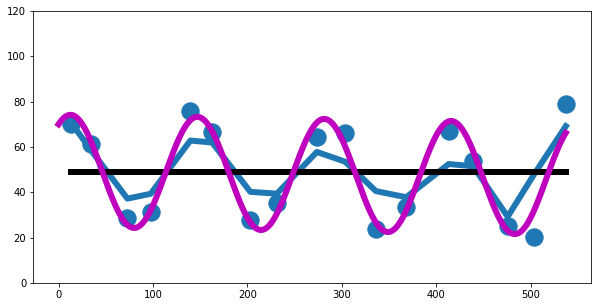

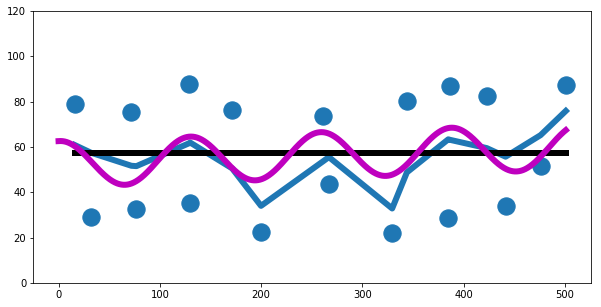

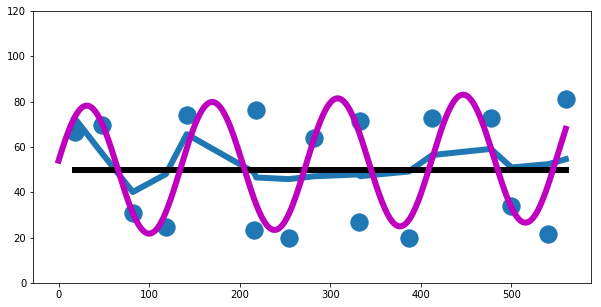

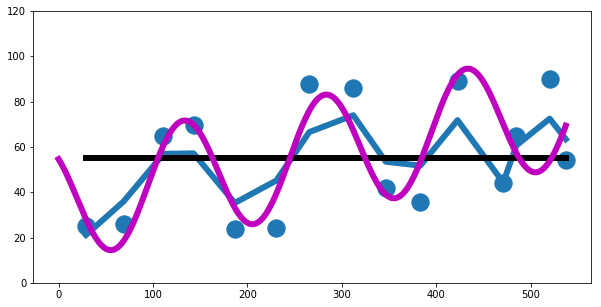

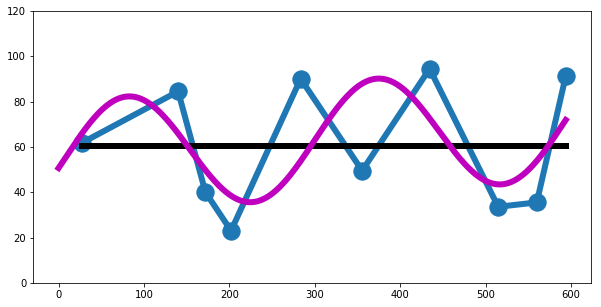

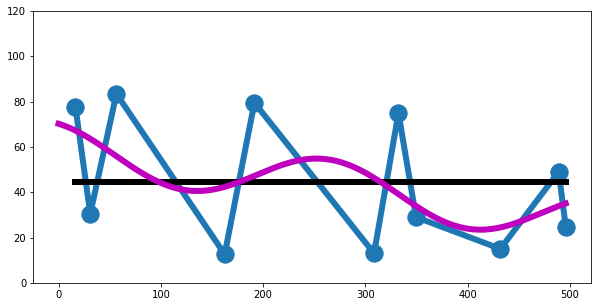

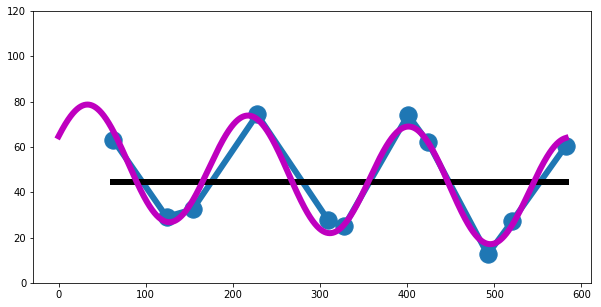

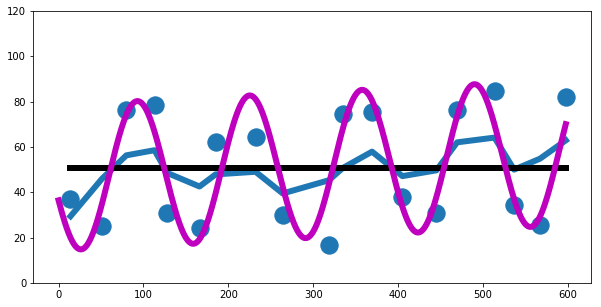

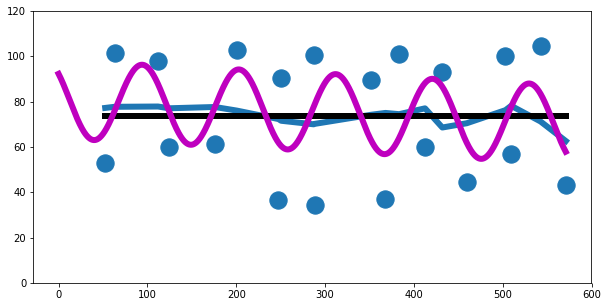

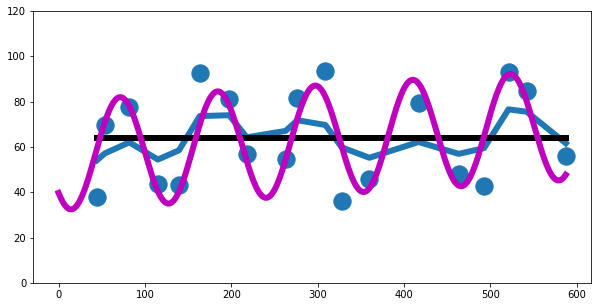

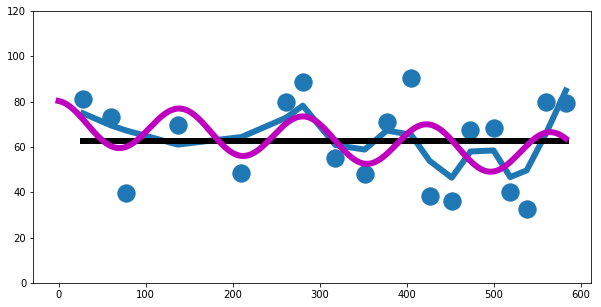

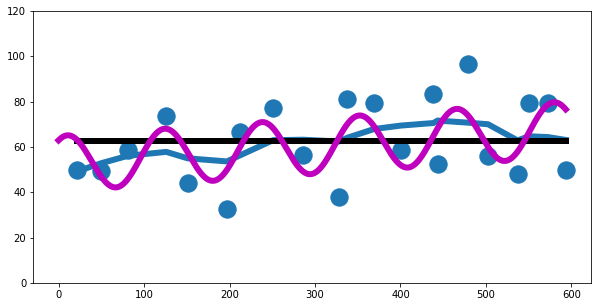

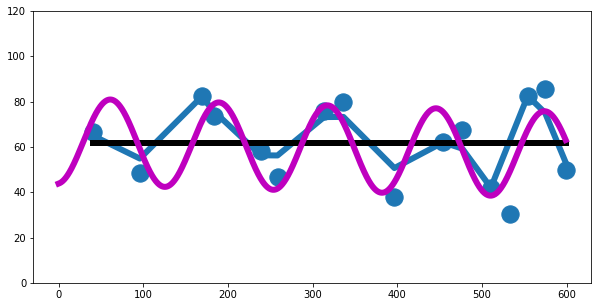

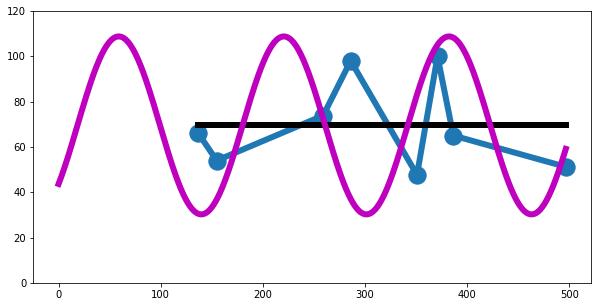

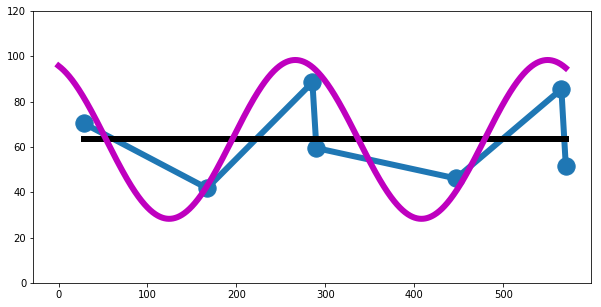

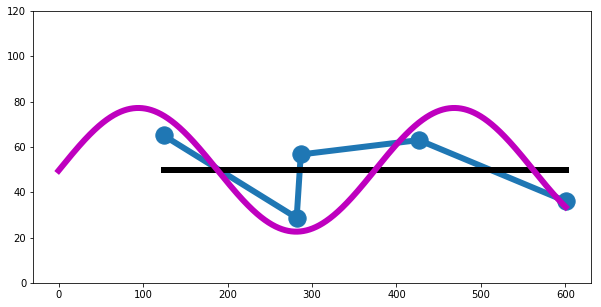

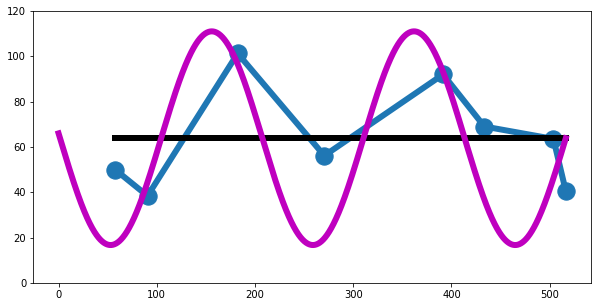

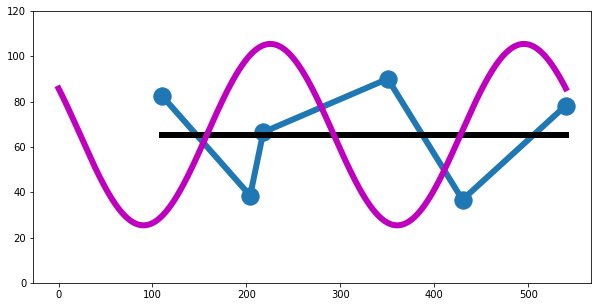

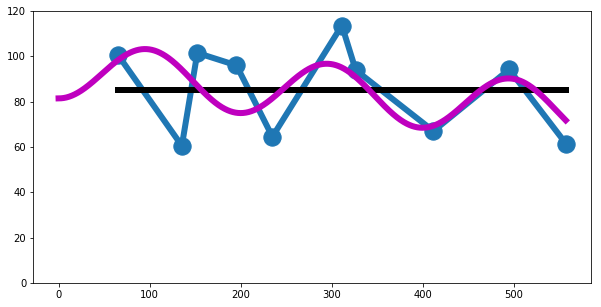

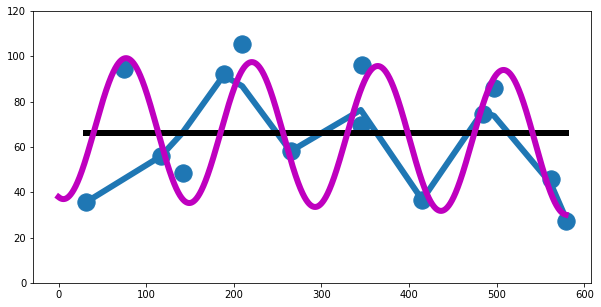

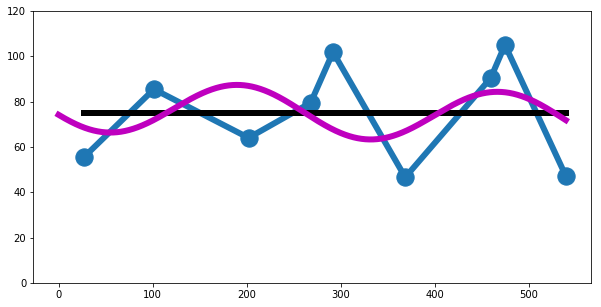

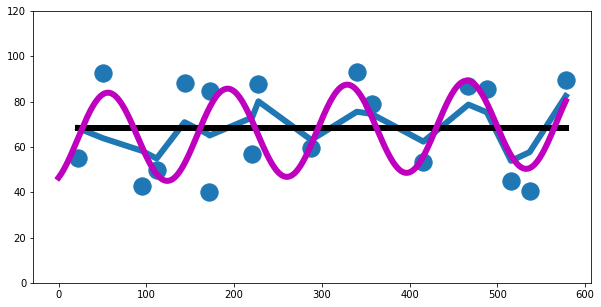

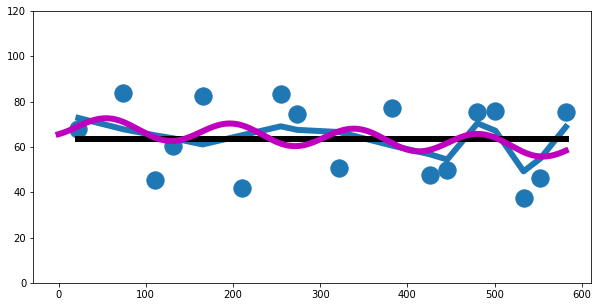

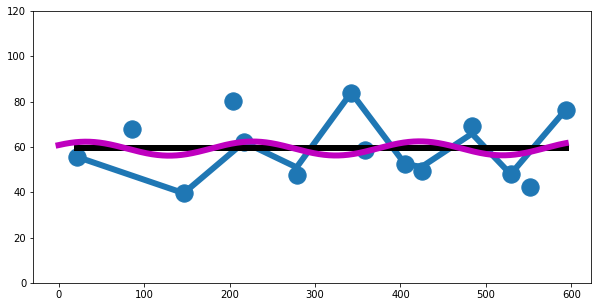

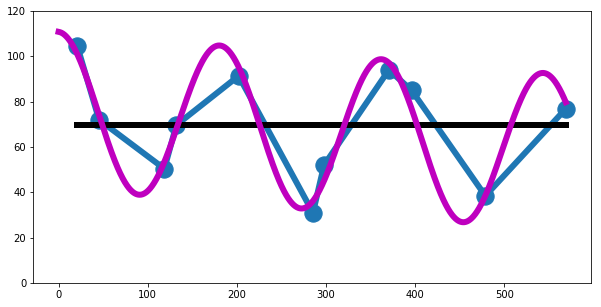

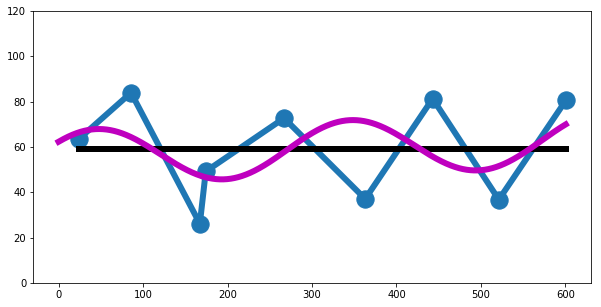

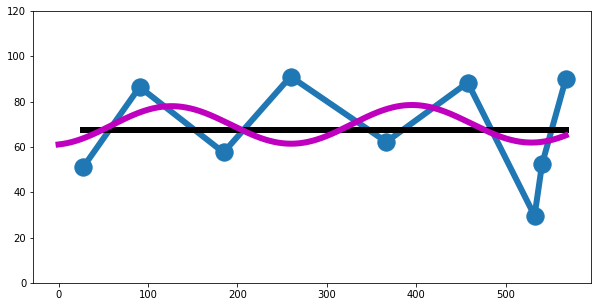

In [12]:
#And this cell does the brunt of the work.

d = {'deviation': [], 'range': [], 'rsd': [], 'amplitude': [], 'period': []}
df = pd.DataFrame(data=d)

for prefix in all_csvs[0:-2]:

    ystd, rang, rsd, amp, per, pawcount, pawdens, cross, crossdens, stride, stridestd = ferret_fit(folder, prefix)
    df = df.append({'deviation':ystd, 'range':rang, 'rsd':rsd, 'amplitude':amp,
                    'pawcount':pawcount, 'pawdensity':pawdens, 'period':per,
                    'cross':cross, 'crossdensity':crossdens, 'stride':stride, 'stridestd':stridestd, 'run':prefix}, ignore_index=True)

In [15]:
df

,amplitude,deviation,period,range,rsd,cross,crossdensity,pawcount,pawdensity,run,stride,stridestd
0,28.329995,22.94,22.888148,63.97,40.0,7.0,1.404537,15.0,3.009721,N_P1_R1,35.598929,7.904682
1,6.499281,23.74,45.568532,61.58,43.0,7.0,1.276366,10.0,1.823380,N_P1_R2,60.936889,23.399999
2,24.748830,20.37,21.376220,58.90,42.0,8.0,1.528406,17.0,3.247864,N_P1_R3,32.713813,7.232158
3,10.149308,25.03,20.500036,66.08,44.0,6.0,1.236932,18.0,3.710797,N_P1_R4,28.533588,19.379037
4,28.657133,23.95,22.039320,61.14,48.0,4.0,0.737719,17.0,3.135305,N_P2_R1,33.888250,19.117453
5,25.685890,24.71,23.850932,66.03,45.0,7.0,1.377782,15.0,2.952390,N_P2_R2,36.290214,9.668581
6,25.296070,26.20,46.490463,71.50,43.0,6.0,1.060071,10.0,1.766784,N_P2_R3,62.888889,27.056436
7,11.085945,27.80,44.065898,70.84,63.0,9.0,1.876904,11.0,2.293994,N_P3_R1,47.951300,38.185976
8,24.736746,21.43,29.317955,61.83,48.0,6.0,1.154959,11.0,2.117425,N_P3_R2,51.949900,23.051705
9,32.114710,23.73,21.067034,68.03,47.0,8.0,1.371225,19.0,3.256659,N_P3_R3,32.412222,10.199793


In [13]:
#This cell allows the user to perform averages of a parameter of interest after analysis and compare groups.

measure = 'period'

print('Mean wonky {}: {} +/- {}'.format(measure, np.average(df[0:15][measure]), sem(df[0:15][measure])))
print('Mean normal {}: {} +/- {}'.format(measure, np.average(df[15:30][measure]), sem(df[15:30][measure])))

np.average(df[0:15]['period'])

Mean wonky period: 26.24057234348273 +/- 2.6633986772950244
Mean normal period: 35.69725047743177 +/- 3.057963429258864


26.240572343482729

In [16]:
#This cell saves the analyzed data to a csv file.
df.to_csv('ferret_stats.csv')

stats = 'ferret_stats.csv'
aws.upload_s3(stats, '{}/{}'.format(folder, stats), bucket_name='ccurtis.data')

In [ ]:
np.arcsin()